In [1]:
from tqdm.notebook import tqdm
from functools import partial

import jax
from jax import numpy as jnp
import numpy as np
import haiku as hk
import optax

from dart import dataset, sample, fields

2022-12-08 21:32:30.542766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-12-08 21:32:30.542833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-12-08 21:32:30.542839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
res = 96
rmin, rmax = 0, 10
dmin, dmax = -5, 5
theta_lim = jnp.pi / 12
phi_lim = jnp.pi / 3

sensor = sample.VirtualRadar(
    r=jnp.linspace(rmin, rmax, res), d=jnp.linspace(dmin, dmax, res),
    theta_lim=theta_lim, phi_lim=phi_lim)

gt = dataset.gt_map("data/map.mat")
ds = dataset.dart("data/traj.mat", "data/sim_96_occ.npz", sensor=sensor)
ds = ds.shuffle(10000, reshuffle_each_iteration=True).batch(32)

render = partial(sensor.render, sigma=gt)
render = jax.jit(jax.vmap(render))

In [3]:
def forward(poses):
    key = hk.next_rng_key()
    keys = jax.random.split(key, poses.v.shape[0])
    sigma = fields.SimpleGrid(
        (100, 100, 100), lower=gt.lower, resolution=gt.resolution * 2)
    return jax.vmap(partial(sensor.render, sigma=sigma))(keys, pose=poses)

dart = hk.transform(forward)

data_trace = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0][0])
params = dart.init(jax.random.PRNGKey(42), data_trace)
key = jax.random.PRNGKey(42)

optimizer = optax.adamw(optax.exponential_decay(
    0.01, 500, 0.01, transition_begin=100, end_value=0.001))
opt_state = optimizer.init(params)

def step(rng, pose, y_true, params, opt_state):

    def loss_func(params):
        y_pred = dart.apply(params, rng, pose)
        return jnp.sum((y_true - y_pred)**2) / y_pred.shape[0]
        # return jnp.mean((y_true - y_pred)**2)
    
    loss, grads = jax.value_and_grad(loss_func)(params)
    loss_clip = jax.tree_util.tree_map(jnp.nan_to_num, grads)
    updates, opt_state = optimizer.update(loss_clip, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = jax.tree_util.tree_map(
        partial(jnp.clip, a_min=0.0, a_max=1.0), params)

    return params, opt_state, loss

for epoch in range(5):
    with tqdm(ds, unit="batch", desc="Epoch {}".format(epoch)) as _epoch:
        avg = 0
        for i, batch in enumerate(_epoch):
            key, rng = jax.random.split(key, 2)
            pose, y_true = jax.tree_util.tree_map(jnp.array, batch)
            params, opt_state, loss = jax.jit(step)(
                rng, pose, y_true, params, opt_state)

            avg = (avg * i + loss) / (i + 1)
            _epoch.set_postfix(loss=avg)

Epoch 0:   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 1:   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 2:   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/313 [00:00<?, ?batch/s]

Epoch 4:   0%|          | 0/313 [00:00<?, ?batch/s]

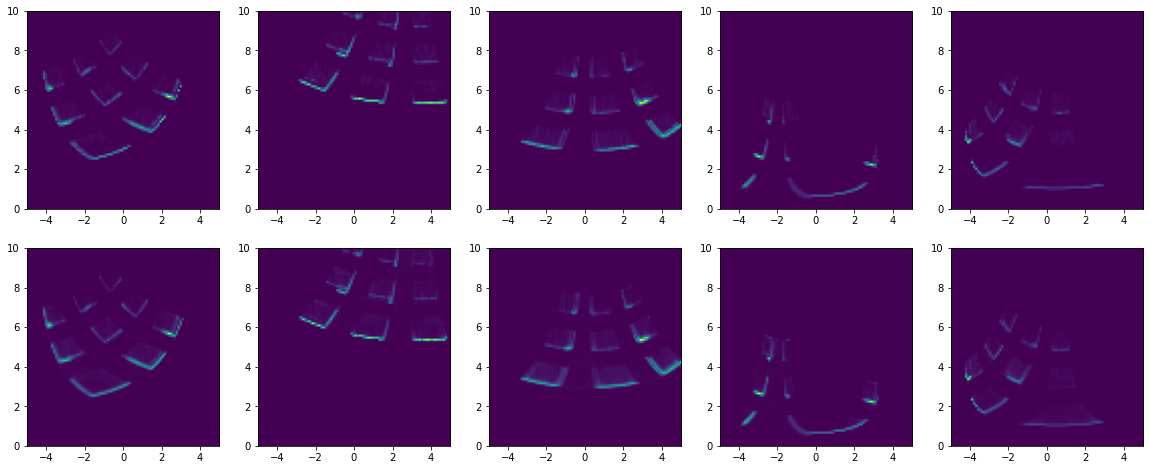

In [4]:
from matplotlib import pyplot as plt

batch = jax.tree_util.tree_map(jnp.array, list(ds.take(1))[0])
pose, y_true = batch

fig, axs = plt.subplots(2, 5, figsize=(20, 8))

extents = np.load("data/sim_96_occ.npz")['extents']

y_pred = dart.apply(params, jax.random.PRNGKey(42), pose)
for y1, y2, col in zip(y_true, y_pred, axs.T):
    col[0].imshow(y1, extent=extents, aspect='auto', origin='lower')
    col[1].imshow(y2, extent=extents, aspect='auto', origin='lower')

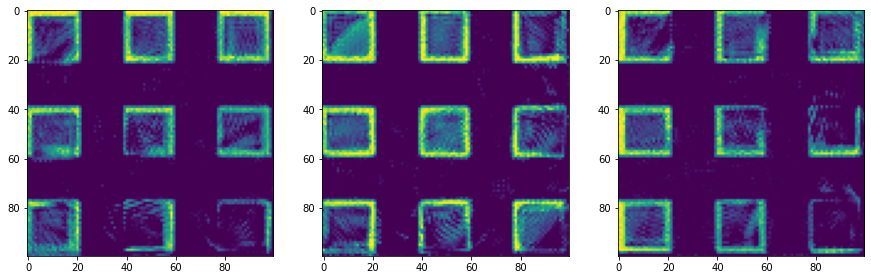

In [9]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for layer, ax in zip([10, 50, 90], axs):
    ax.imshow(params['simple_grid']['grid'][:, :, layer])